In [22]:
import glob
import os
import pandas as pd
import PIL 
from PIL import Image, ImageDraw
from collections import Counter
import numpy as np
from helpers import read_project_variables, return_whole_dataset, count_IoU
from models import PCA, NearestCentroid, AdaBoost
import cv2
import tqdm
import itertools
from matplotlib import pyplot as plt
import pickle
variables = read_project_variables()

In [23]:
dataset = return_whole_dataset()

100%|█████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 315.35it/s]


In [24]:
desk_files = set(np.genfromtxt('desk_files.csv',dtype=None, encoding='utf-8'))

In [25]:
dataset_desk = [elem for elem in dataset if elem[0] in desk_files]
dataset_floor = [elem for elem in dataset if elem[0] not in desk_files]

In [26]:
def get_images_and_classes(dataset): 
    result = []
    for row in dataset: 
        for class_, bb in zip(row[3], row[2]): 
            image = row[1].crop(bb)
            result.append((image, class_))
    return result
    
coin_images_desk = get_images_and_classes(dataset_desk)
coin_images_floor = get_images_and_classes(dataset_floor)

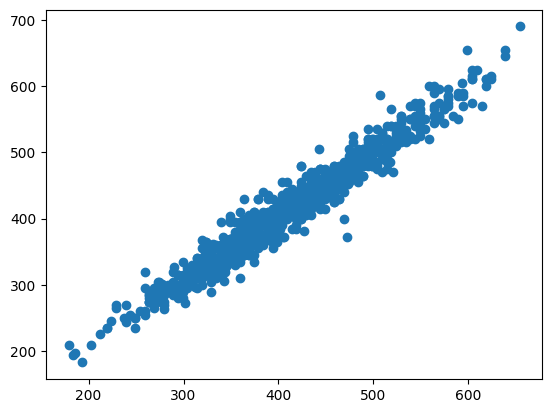

In [27]:
sizes = np.array([row[0].size for row in coin_images_desk+coin_images_floor])
plt.scatter(sizes[:, 0], sizes[:, 1])

In [28]:
from sklearn.model_selection import train_test_split


In [29]:
def save_model(model, file):
    with open(file, 'wb') as f: 
        pickle.dump(model, f)
    
def load_model(file): 
    with open(file, 'rb') as f: 
        return pickle.load(f)

In [30]:
coin_to_group = {'1gr': 0,'2gr': 0, '5gr': 0,'10gr': 1, '20gr': 1,'50gr': 1, '1zl': 1,'2zl': 2, '5zl': 2}
coin_to_label = {'1gr': 0,'2gr': 1, '5gr': 2, '10gr': 3, '20gr': 4, '50gr': 5, '1zl': 6,'2zl': 7, '5zl': 8}
label_to_coin = {y:x for x, y in coin_to_label.items()}

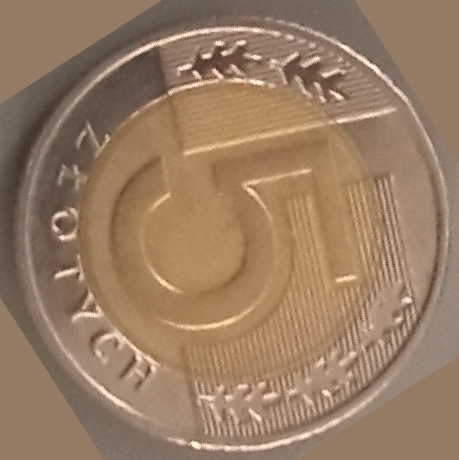

In [31]:
def aug_dataset(coin_images,num_images=3): 
    auged = []
    for image, class_ in coin_images: 
        for _ in range(num_images):
            auged.append((return_rotated_image(image), class_))
    return coin_images + auged
def return_rotated_image(image):
    return image.rotate(np.random.uniform(0, 360), 
              fillcolor=tuple(np.array(image).mean(axis=0).mean(axis=0).astype(np.uint8)))    
return_rotated_image(coin_images_desk[10][0])

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
def summary(clf, pca_features_train, pca_features_test, train_y, test_y, title): 
    fig, ax = plt.subplots(figsize=(9,6))
    acc_train = clf.score(pca_features_train, train_y)
    
    acc_test = clf.score(pca_features_test, test_y)
    y_pred = clf.predict(pca_features_test)
    classes  = sorted(np.unique(test_y))
    cm = confusion_matrix(test_y, y_pred, labels=classes)
    df = pd.DataFrame(cm, index=[f'T{label_to_coin[class_]}' for class_ in classes],
                          columns=[label_to_coin[class_] for class_ in classes])
    sn.heatmap(df, annot=True, ax=ax, fmt='d')
    ax.set_title(title)
    fig.savefig(f'summary/{title}.png')
    return acc_train, acc_test

In [65]:
from xgboost import XGBClassifier
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.preprocessing import MinMaxScaler
import importlib
import warnings
def train_model(dataset_name, model_name, image_size=50, pca_components=30, train_pca_if_exists=False, tree_max_depth=3, num_aug=10): 
    if dataset_name == 'floor': 
        coin_images = coin_images_floor
    elif dataset_name == 'desk': 
        coin_images = coin_images_desk
    else: 
        coin_images = coin_images_desk + coin_images_floor
     
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        np.random.RandomState(seed=42).permutation(coin_images)
        coin_images = [[row[0].resize((image_size,image_size))] + list(row[1:]) for row in coin_images]

        train, test = train_test_split(coin_images, test_size=0.2, random_state=42)
        train = aug_dataset(train, num_aug)
        train, test = np.array(train, dtype=object), np.array(test, dtype=object)

    train_x, train_y = train[:, 0], train[:, 1]
    test_x, test_y = test[:, 0], test[:, 1]
    train_x = [np.array(image) for image in train_x]
    test_x = [np.array(image) for image in test_x]
    
    train_y = np.array([coin_to_label[class_] for class_ in train_y])
    test_y = np.array([coin_to_label[class_] for class_ in test_y])
    
    features_train = np.array([image.flatten() for image in train_x])
    features_test = np.array([image.flatten() for image in test_x])
    
    if os.path.exists(f'pca_{image_size}x{image_size}_{dataset_name}.pickle') and not train_pca_if_exists: 
        pca = load_model(f'pca_{image_size}x{image_size}_{dataset_name}.pickle')
    else: 
        pca = PCA()
        pca.fit(features_train)
        save_model(pca, f'pca_{image_size}x{image_size}_{dataset_name}.pickle')

    pca_features_train = pca.transform(features_train, pca_components).real
    
    scaler = MinMaxScaler()
    pca_features_train = scaler.fit_transform(pca_features_train)
    pca_features_test = pca.transform(features_test, pca_components).real
    
    pca_features_test = scaler.transform(pca_features_test)
    if model_name =='adaboost': 
        clf = AdaBoost(n_iters=30, tree_max_depth=tree_max_depth)
    elif model_name == 'NC':
        clf = NearestCentroid()
    else: 
        clf = XGBClassifier()
    
    clf.fit(pca_features_train, np.array(train_y))
    if model_name =='adaboost':
        clf.load_best()
    
    title = f'model_{model_name}_comp_{pca_components}_dataset_{dataset_name}'
    if model_name =='NC':
        save_model(clf, f'models/{title}.pickle')
        save_model(scaler, f'models/scaler_{title}.pickle')
    plt.close()
    return summary(clf, pca_features_train, pca_features_test, train_y, test_y, title)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [03:43<00:00, 17.21s/it]


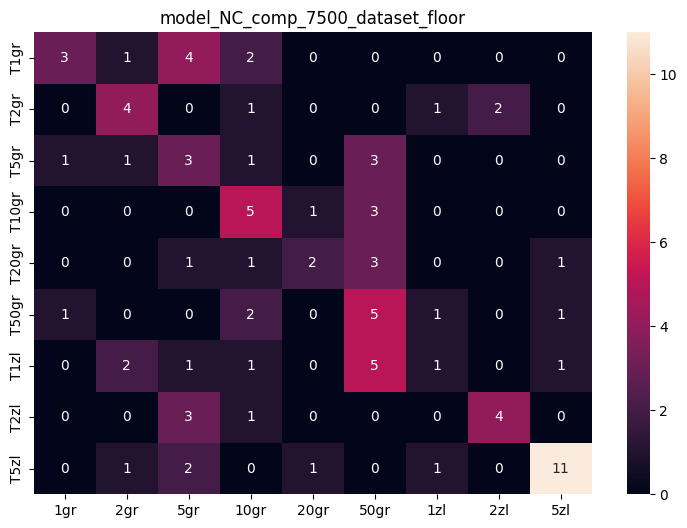

In [36]:
stats_all = []
for n_components in tqdm.tqdm([1,2,3,4,5,6,20,50,100,1000,2000,3000,7500]):
    for dataset_name in ['all', 'desk', 'floor']: 
        stats = train_model(dataset_name,  'NC', image_size=50, tree_max_depth=1,pca_components=n_components)
        stats_all.append((dataset_name, 'NC',n_components, stats[0], stats[1]))

In [37]:
stats_all_df = pd.DataFrame(stats_all, columns=['dataset_name', 'model_name','n_components', 'acc_train', 'acc_test'])

   dataset_name model_name  n_components  acc_train  acc_test
27          all         NC          1000   0.725256  0.511765
   dataset_name model_name  n_components  acc_train  acc_test
28         desk         NC          1000   0.834375  0.765432
   dataset_name model_name  n_components  acc_train  acc_test
20        floor         NC            20   0.554903  0.651685
23        floor         NC            50   0.621553  0.651685


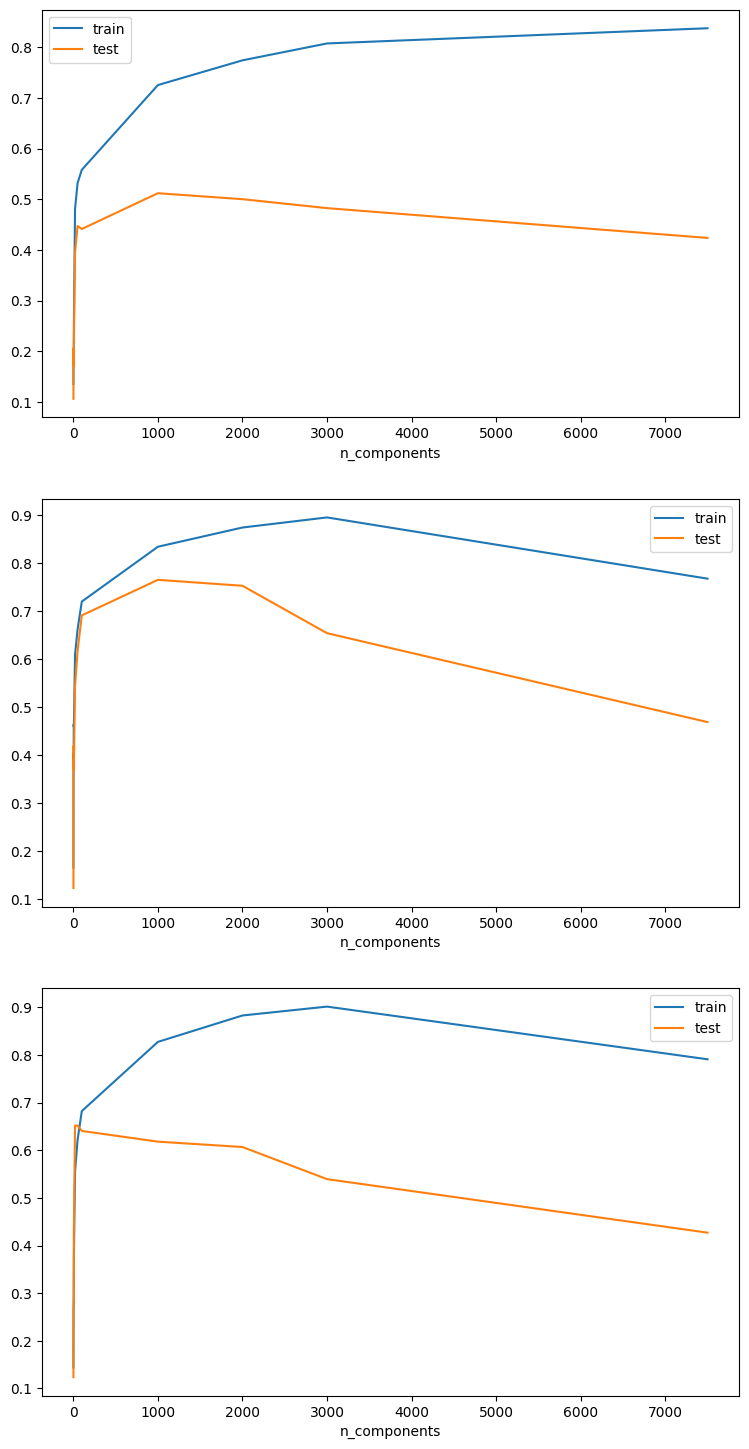

In [38]:
best_components = {}
fig, axs = plt.subplots(figsize=(9,3*6), nrows=3)
for i, dataset_name in enumerate(['all', 'desk', 'floor']):
    tmp = stats_all_df[stats_all_df['dataset_name'] == dataset_name]
    best = tmp[tmp['acc_test'] == tmp['acc_test'].max()]
    print(best)
    best_components[best['dataset_name'].iloc[0]] = best['n_components'].iloc[0]
    axs[i].plot(tmp['n_components'], tmp['acc_train'], label='train')
    axs[i].plot(tmp['n_components'], tmp['acc_test'], label='test')
    axs[i].legend()
    axs[i].set_xlabel('n_components')

In [39]:
len(stats_all)

39

In [ ]:
for n_components in tqdm.tqdm([1,2,3,4,5,6,20,50]):
    for dataset_name in ['all', 'desk', 'floor']: 
        stats = train_model(dataset_name,  'adaboost', image_size=50, tree_max_depth=1,pca_components=n_components, num_aug=3)
        stats_all.append((dataset_name, 'adaboost',n_components, stats[0], stats[1]))

In [ ]:
for n_components in tqdm.tqdm([1,2,3,4,5,6,20,50]):
    for dataset_name in ['all', 'desk', 'floor']: 
        stats = train_model(dataset_name,  'xgboost', image_size=50, tree_max_depth=1,pca_components=best_components[dataset_name])
        stats_all.append((dataset_name, 'xgboost',best_components[dataset_name], stats[0], stats[1]))

In [54]:
stats_all_df = pd.DataFrame(stats_all, columns=['dataset_name', 'model_name','n_components', 'acc_train', 'acc_test'])

In [63]:
def get_best(x): 
    best = np.argmax(x['acc_test'])
    result = {col:x[col].iloc[best] for col in ['n_components','acc_train','acc_test']}
    return pd.Series(result, index=result.keys())
final_summary = stats_all_df.groupby(['dataset_name','model_name']).apply(get_best).reset_index()
final_summary['acc_train'] = final_summary['acc_train'].apply(lambda x: round(100*x, 2))
final_summary['acc_test'] = final_summary['acc_test'].apply(lambda x: round(100*x, 2))
final_summary

,dataset_name,model_name,n_components,acc_train,acc_test
0,all,NC,1000.0,72.53,51.18
1,all,adaboost,20.0,27.63,17.06
2,all,xgboost,1000.0,100.00,67.06
3,desk,NC,1000.0,83.44,76.54
4,desk,adaboost,2.0,25.16,28.40
5,desk,xgboost,1000.0,100.00,71.60
6,floor,NC,20.0,55.49,65.17
7,floor,adaboost,20.0,23.17,21.35
8,floor,xgboost,20.0,100.00,68.54


<BarContainer object of 10 artists>

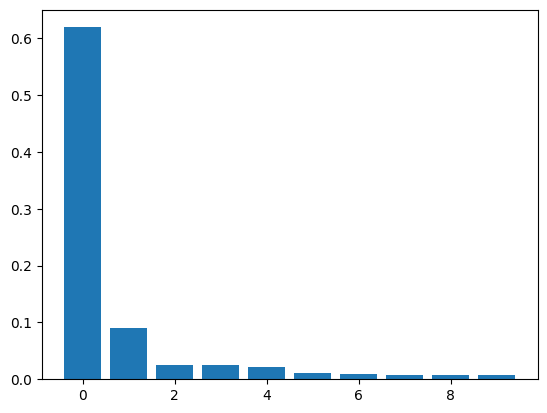

In [64]:
desk_pca = load_model('pca_50x50_floor.pickle')
ratio = desk_pca.eigenvalues[desk_pca.sort_indices].real/sum(desk_pca.eigenvalues.real)
plt.bar(range(10), ratio[:10])